# MP2 二阶梯度：微分 Z-Vector 方程

这份文档将会从 MP2 一阶梯度公式出发，推导二阶梯度的表达式并程序化．Cammi, R. et al TCA 2004, 111, 66-77 (doi: 10.1007/s00214-003-0521-8) 提供的非常好的思路；但这篇文章使用到稍微复杂的轨道旋转，而轨道旋转不太适合使用矩阵的数值导数直接验证，一些变量也会相应地不太直观．因此，我们将会使用 Canonical HF 的轨道重新描述微分 Z-Vector 方程．

In [1]:
import numpy as np
from pyscf import scf, gto, lib, grad, hessian, dft, mp
import pyscf.hessian.rks
import pyscf.grad.rks
from functools import partial
import pickle
import matplotlib.pyplot as plt

from utilities import val_from_fchk, NumericDiff
from hessian import HFHelper, GGAHelper

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.einsum_path = partial(np.einsum_path, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(6, linewidth=150, suppress=True)

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

nmo = nao = mol.nao
natm = mol.natm
nocc = mol.nelec[0]
nvir = nmo - nocc
so = slice(0, nocc)
sv = slice(nocc, nmo)
sa = slice(0, nmo)

### 文档定义所用变量

In [3]:
# We use U_1 in this document, but no U_2
# We still using MO basis ERI
# Pre-generate some code here will make later work quicker
# But these operations are numerical-unstable or memory consuming
hfh = HFHelper(mol)
hfh.U_1
hfh.eri0_mo
hfh.eri1_mo
hfh.eri2_mo
hfh

/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:366: UserWarning: U_1: Generating total U matrix should be considered as numerical unstable!
  warnings.warn("U_1: Generating total U matrix should be considered as numerical unstable!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:229: UserWarning: eri0_mo: ERI AO -> MO is quite expensive!
  warnings.warn("eri0_mo: ERI AO -> MO is quite expensive!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:222: UserWarning: eri0_ao: ERI should not be stored in memory! Consider J/K engines!
  warnings.warn("eri0_ao: ERI should not be stored in memory! Consider J/K engines!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:279: UserWarning: eri1_mo: 4-idx tensor ERI should be not used!
  warnings.warn("eri1_mo: 4-idx tensor ERI should be not used!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:272: UserWarning: eri1_ao: 4-idx tensor ERI should be not used!
  w

In [4]:
e, eo, ev = hfh.e, hfh.eo, hfh.ev
C, Co, Cv = hfh.C, hfh.Co, hfh.Cv
D = hfh.D
eri0_mo = hfh.eri0_mo
eri1_mo = hfh.eri1_mo
eri2_mo = hfh.eri2_mo

F_1_mo = hfh.F_1_mo
S_1_mo = hfh.S_1_mo
U_1_vo = hfh.U_1_vo
U_1 = hfh.U_1  # Only for verify
B_1 = hfh.B_1
Ax0_Core = hfh.Ax0_Core

MP2 Hessian 参考值如下：

In [5]:
g_array = val_from_fchk("Cartesian Force Constants", "include/mp2_hess/mp2_hess.fchk")
d_hess = natm * 3
hess_mp2_gaussian = np.zeros((d_hess, d_hess))
p = 0
for d1 in range(d_hess):
    for d2 in range(d1 + 1):
        hess_mp2_gaussian[d1][d2] = hess_mp2_gaussian[d2][d1] = g_array[p]
        p += 1
hess_mp2_gaussian = hess_mp2_gaussian.reshape((natm, 3, natm, 3)).swapaxes(1, 2)
hess_mp2_ref = hess_mp2_gaussian - hfh.scf_hess.kernel()

## MP2 一阶梯度：回顾与变量定义

MP2 PySCF 类

In [6]:
hfh.scf_grad.kernel()
mp2_eng = mp.MP2(hfh.scf_eng)
mp2_eng.kernel()[0]
mp2_grad = grad.mp2.Gradients(mp2_eng)
mp2_grad.kernel()

array([[-0.102293,  0.014371,  0.031588],
       [ 0.008573,  0.75439 , -0.009366],
       [ 0.087807,  0.00276 ,  0.014487],
       [ 0.005914, -0.77152 , -0.036708]])

双电子积分

In [7]:
g_mo = eri0_mo
G_mo = 2 * g_mo - g_mo.swapaxes(-1, -3)
g_iajb = g_mo[so, sv, so, sv]
G_iajb = G_mo[so, sv, so, sv]

双电子积分的 Skeleton 梯度

In [8]:
pd_g_mo = eri1_mo
pd_G_mo = 2 * pd_g_mo - pd_g_mo.swapaxes(-1, -3)
pd_g_iajb = pd_g_mo[:, :, so, sv, so, sv]
pd_G_iajb = pd_G_mo[:, :, so, sv, so, sv]

MP2 Amplitude 与能量计算相关表达式

In [9]:
# Define t, g
D_iajb = lib.direct_sum("i - a + j - b", eo, ev, eo, ev)
t_iajb = g_iajb / D_iajb
T_iajb = 2 * t_iajb - t_iajb.swapaxes(-1, -3)
D_mo = lib.direct_sum("i - a + j - b", e, e, e, e)
t_mo = g_mo / D_mo
T_mo = 2 * t_mo - t_mo.swapaxes(-1, -3)

/share/home/zyzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/share/home/zyzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


验证 MP2 能量

In [10]:
np.allclose((t_iajb * T_iajb * D_iajb).sum(), mp2_eng.e_corr)

True

弛豫密度、加权密度相关量定义

In [11]:
D_r = np.zeros((nmo, nmo))
D_r[so, so] += - 2 * np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)
D_r[sv, sv] += 2 * np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)

L = np.zeros((nvir, nocc))
L += Ax0_Core(sv, so, sa, sa)(D_r)
L -= 4 * np.einsum("jakb, ijbk -> ai", T_iajb, g_mo[so, so, sv, so])
L += 4 * np.einsum("ibjc, abjc -> ai", T_iajb, g_mo[sv, sv, so, sv])

D_r[sv, so] = scf.cphf.solve(Ax0_Core(sv, so, sv, so), e, hfh.mo_occ, L, max_cycle=100, tol=1e-13)[0]

In [12]:
# W[I] - Correct with s1-im1 term in PySCF
D_WI = np.zeros((nmo, nmo))
D_WI[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, g_mo[so, sv, so, sv])
D_WI[sv, sv] = - 2 * np.einsum("iajc, ibjc -> ab", T_iajb, g_mo[so, sv, so, sv])
D_WI[sv, so] = - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, g_mo[so, so, sv, so])

# W[II] - Correct with s1-zeta term in PySCF
# Note that zeta in PySCF includes HF energy weighted density rdm1e
# The need of scaler 1 in D_WII[sv, so] is that Aikens use doubled P
D_WII = np.zeros((nmo, nmo))
D_WII[so, so] = - 0.5 * D_r[so, so] * lib.direct_sum("i + j -> ij", eo, eo)
D_WII[sv, sv] = - 0.5 * D_r[sv, sv] * lib.direct_sum("a + b -> ab", ev, ev)
D_WII[sv, so] = - D_r[sv, so] * eo

# W[III] - Correct with s1-vhf_s1occ term in PySCF
D_WIII = np.zeros((nmo, nmo))
D_WIII[so, so] = - 0.5 * Ax0_Core(so, so, sa, sa)(D_r)

# Summation
D_W = D_WI + D_WII + D_WIII

验证 MP2 一阶梯度，这里采用的一阶梯度公式是

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = D_{pq}^\mathrm{MP2} F_{pq}^{A_t} + W_{pq}^\mathrm{MP2} S_{pq}^{A_t} + 2 T_{ij}^{ab} (\partial_{A_t} g_{ij}^{ab})
$$

In [13]:
np.allclose(
    + (D_r * F_1_mo).sum(axis=(-1, -2))
    + (D_W * S_1_mo).sum(axis=(-1, -2))
    + (2 * T_iajb * pd_g_iajb).sum(axis=(-1, -2, -3, -4)),
    mp2_grad.de - hfh.scf_grad.de
)

True

## MP2 二阶梯度：微分 Z-Vector 方程的不安全实现

通过微分 Z-Vector 方程求解 MP2 Hessian 的过程，实际上仅仅是对使用弛豫密度、加权密度等表示的 MP2 梯度，直接进行再一次求导．如果 MP2 一阶梯度表示为

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = (\frac{\partial}{\partial A_t} T_{ij}^{ab}) t_{ij}^{ab} D_{ij}^{ab} + T_{ij}^{ab} (\frac{\partial}{\partial A_t} t_{ij}^{ab}) D_{ij}^{ab} + T_{ij}^{ab} t_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab})
$$

那么 MP2 的二阶梯度可以表示为

\begin{align}
E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s} =
&+ D_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} F_{pq}^{A_t}) + W_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} S_{pq}^{A_t}) \\
&+ (\frac{\partial}{\partial B_s} D_{pq}^\mathrm{MP2}) F_{pq}^{A_t} + (\frac{\partial}{\partial B_s} W_{pq}^\mathrm{MP2}) S_{pq}^{A_t} \\
&+ 2 (\frac{\partial}{\partial B_s} T_{ij}^{ab}) (\partial_{A_t} g_{ij}^{ab}) + 2 T_{ij}^{ab} (\frac{\partial}{\partial B_s} \partial_{A_t} g_{ij}^{ab})
\end{align}

我们简单地称这些项是 MP2 Hessian 的六个贡献项．其中，在现在的推导框架下，第 1, 2, 5, 6 很快可以被求出．

### 第一贡献项 $D_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} F_{pq}^{A_t})$

这一项的难点仅仅在于求取 Fock 一阶 Skeleton 梯度的一阶全导数．我们通过下面的程序验证我们可以生成正确的 `pdA_F_1_mo` $\frac{\partial}{\partial B_s} F_{pq}^{A_t}$：

In [14]:
def mol_to_F_1_mo(mol):
    return HFHelper(mol).F_1_mo
F_1_mo_diff = NumericDiff(mol, mol_to_F_1_mo, deriv=2, symm=False).get_numdif()

In [15]:
pdA_F_1_mo = (
    + hfh.F_2_mo
    + np.einsum("Atpm, Bsmq -> ABtspq", hfh.F_1_mo, U_1)
    + np.einsum("Atmq, Bsmp -> ABtspq", hfh.F_1_mo, U_1)
    + hfh.Ax1_Core(sa, sa, sa, so)(U_1[:, :, :, so])
)

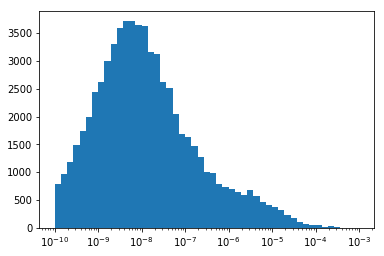

In [16]:
plt.hist(abs(pdA_F_1_mo - F_1_mo_diff).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(1e-3), 50))
plt.gca().set_xscale("log")

因此，第一贡献项 `hess_mp2_unsafe_contrib1` $D_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} F_{pq}^{A_t})$ 可以非常直观地写出：

In [17]:
hess_mp2_unsafe_contrib1 = np.einsum("pq, ABtspq -> ABts", D_r, pdA_F_1_mo)

### 第二贡献项 $W_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} S_{pq}^{A_t})$

这一项的难点也仅仅在于求取 `pdA_S_1_mo` $(\frac{\partial}{\partial B_s} S_{pq}^{A_t})$．

In [18]:
def mol_to_S_1_mo(mol):
    return HFHelper(mol).S_1_mo
S_1_mo_diff = NumericDiff(mol, mol_to_S_1_mo, deriv=2, symm=False).get_numdif()

In [19]:
pdA_S_1_mo = (
    + hfh.S_2_mo
    + np.einsum("Atpm, Bsmq -> ABtspq", hfh.S_1_mo, U_1)
    + np.einsum("Atmq, Bsmp -> ABtspq", hfh.S_1_mo, U_1)
)

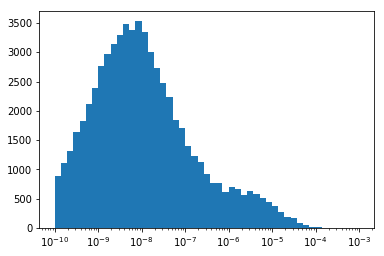

In [20]:
plt.hist(abs(pdA_S_1_mo - S_1_mo_diff).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(1e-3), 50))
plt.gca().set_xscale("log")

第二贡献项 `hess_mp2_unsafe_contrib2` $W_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} S_{pq}^{A_t})$ 也可以非常直观地写出：

In [21]:
hess_mp2_unsafe_contrib2 = np.einsum("pq, ABtspq -> ABts", D_W, pdA_S_1_mo)

### 第五、六贡献项 $2 (\frac{\partial}{\partial B_s} T_{ij}^{ab}) (\partial_{A_t} g_{ij}^{ab}) + 2 T_{ij}^{ab} (\frac{\partial}{\partial B_s} \partial_{A_t} g_{ij}^{ab})$

在求取第五、第六贡献项前，我们需要简单回顾一下暴力求解 MP2 梯度时所使用的生成类似于 $\frac{\partial}{\partial A_t} g_{ij}^{ab}$ 的方式．这种方式尽管非常占用内存资源，但在实践中很可能无法避免，至少如果不打算牺牲太多代码可读性时应是不可避免的．

(注意这个文档块的 $i, a, j, b$ 在代码中可能代表全轨道)

* `pd_g_mo`:  $\partial_{A_t} g_{ij}^{ab} = (ia|jb)^{A_t}$

* `pdU_g_mo`: $\partial_{A_t}^\mathrm{U} g_{ij}^{ab} = g_{pj}^{ab} U_{pi}^\mathrm{A_t} + g_{ip}^{ab} U_{pj}^\mathrm{A_t} + g_{ij}^{pb} U_{pa}^\mathrm{A_t} + g_{ij}^{ap} U_{pb}^\mathrm{A_t}$

* `pdA_g_mo`: $\frac{\partial}{\partial A_t} g_{ij}^{ab} = \partial_{A_t} g_{ij}^{ab} + \partial_{A_t}^\mathrm{U} g_{ij}^{ab}$

* `pdA_G_mo`: $\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab} = 2 \frac{\partial}{\partial A_t} g_{ij}^{ab} - \frac{\partial}{\partial A_t} g_{ij}^{ba}$

* `pdA_g_iajb`: `pdA_g_mo` 的分割

* `pdA_G_iajb`: `pdA_G_mo` 的分割

In [22]:
pd_g_mo = eri1_mo
pdU_g_mo = (
    + np.einsum("pjkl, Atpi -> Atijkl", g_mo, U_1)
    + np.einsum("ipkl, Atpj -> Atijkl", g_mo, U_1)
    + np.einsum("ijpl, Atpk -> Atijkl", g_mo, U_1)
    + np.einsum("ijkp, Atpl -> Atijkl", g_mo, U_1)
)
pdA_g_mo = pd_g_mo + pdU_g_mo
pdA_G_mo = 2 * pdA_g_mo - pdA_g_mo.swapaxes(-1, -3)

pdA_g_iajb = pdA_g_mo[:, :, so, sv, so, sv]
pdA_G_iajb = pdA_G_mo[:, :, so, sv, so, sv]

* `pd_pd_g_mo`: $\partial_{B_s} \partial_{A_t} g_{ij}^{ab} = (ia|jb)^{A_t B_s}$

* `pdU_pd_g_mo`: $\partial_{B_s}^\mathrm{U} \partial_{A_t} g_{ij}^{ab} = \partial_{A_t} g_{pj}^{ab} U_{pi}^\mathrm{B_s} + \partial_{A_t} g_{ip}^{ab} U_{pj}^\mathrm{B_s} + \partial_{A_t} g_{ij}^{pb} U_{pa}^\mathrm{B_s} + \partial_{A_t} g_{ij}^{ap} U_{pb}^\mathrm{B_s}$

* `pdA_pd_g_mo`: $\frac{\partial}{\partial B_s} \partial_{A_t} g_{ij}^{ab} = \partial_{B_s} \partial_{A_t} g_{ij}^{ab} + \partial_{B_s}^\mathrm{U} \partial_{A_t} g_{ij}^{ab}$

* `pdA_pd_g_iajb`: `pdA_pd_g_mo` 的分割

In [23]:
pd_pd_g_mo = eri2_mo
pdU_pd_g_mo = (
    # pd on g, U matrix on B
    + np.einsum("Atpjkl, Bspi -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atipkl, Bspj -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atijpl, Bspk -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atijkp, Bspl -> ABtsijkl", pd_g_mo, U_1)
)
pdA_pd_g_mo = pd_pd_g_mo + pdU_pd_g_mo
pdA_pd_g_iajb = pdA_pd_g_mo[:, :, :, :, so, sv, so, sv]

* `e_1`: $\varepsilon_p^{A_t} = \frac{\partial}{\partial A_t} \varepsilon = B_{pp}^{A_t} + A_{pp, bj} U_{bj}^{A_t}$

* `eo_1`, `ev_1`: `e_1` 的分割

* `pdA_D_iajb`: $\frac{\partial}{\partial A_t} D_{ij}^{ab} = \varepsilon_i^{A_t} - \varepsilon_a^{A_t} + \varepsilon_j^{A_t} - \varepsilon_b^{A_t}$

In [24]:
e_1 = (B_1 + Ax0_Core(sa, sa, sv, so)(U_1_vo)).diagonal(0, -1, -2)
eo_1, ev_1 = e_1[:, :, so], e_1[:, :, sv]

pdA_D_iajb = (
    + eo_1[:, :, :, None, None, None]
    - ev_1[:, :, None, :, None, None]
    + eo_1[:, :, None, None, :, None]
    - ev_1[:, :, None, None, None, :]
)

* `pdA_t_iajb`: $\frac{\partial}{\partial A_t} t_{ij}^{ab} = (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (D_{ij}^{ab})^{-1} - t_{ij}^{ab} (D_{ij}^{ab})^{-1} \frac{\partial}{\partial A_t} D_{ij}^{ab}$

* `pdA_T_iajb`: $\frac{\partial}{\partial A_t} T_{ij}^{ab} = 2 \frac{\partial}{\partial A_t} t_{ij}^{ab} - \frac{\partial}{\partial A_t} t_{ij}^{ba}$

In [25]:
pdA_t_iajb = (
    + pdA_g_iajb / D_iajb
    - np.einsum("Atiajb, iajb, iajb -> Atiajb", pdA_D_iajb, t_iajb, 1 / D_iajb)
)
pdA_T_iajb = 2 * pdA_t_iajb - pdA_t_iajb.swapaxes(-1, -3)

我们可以预先验证 MP2 能量 $E_\mathrm{elec}^\mathrm{MP2} = T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab}$ 的一阶梯度在这种表示下是成立的：

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = (\frac{\partial}{\partial A_t} T_{ij}^{ab}) t_{ij}^{ab} D_{ij}^{ab} + T_{ij}^{ab} (\frac{\partial}{\partial A_t} t_{ij}^{ab}) D_{ij}^{ab} + T_{ij}^{ab} t_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab})
$$

In [26]:
(
    + np.einsum("Atiajb, iajb, iajb -> At", pdA_t_iajb, T_iajb, D_iajb)
    + np.einsum("iajb, Atiajb, iajb -> At", t_iajb, pdA_T_iajb, D_iajb)
    + np.einsum("iajb, iajb, Atiajb -> At", t_iajb, T_iajb, pdA_D_iajb)
) - (mp2_grad.de - hfh.scf_grad.de)

array([[-0., -0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.],
       [-0., -0., -0.]])

我们也可以验证 MP2 能量 $E_\mathrm{elec}^\mathrm{MP2} = T_{ij}^{ab} g_{ij}^{ab}$ 所表示的一阶梯度：

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = (\frac{\partial}{\partial A_t} T_{ij}^{ab}) g_{ij}^{ab} + T_{ij}^{ab} (\frac{\partial}{\partial A_t} g_{ij}^{ab})
$$

In [27]:
(
    + np.einsum("Atiajb, iajb -> At", pdA_T_iajb, g_iajb)
    + np.einsum("iajb, Atiajb -> At", T_iajb, pdA_g_iajb)
) - (mp2_grad.de - hfh.scf_grad.de)

array([[-0., -0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.],
       [-0., -0., -0.]])

由此，第 5, 6 贡献项 `hess_mp2_unsafe_contrib5_6` $2 (\frac{\partial}{\partial B_s} T_{ij}^{ab}) (\partial_{A_t} g_{ij}^{ab}) + 2 T_{ij}^{ab} (\frac{\partial}{\partial B_s} \partial_{A_t} g_{ij}^{ab})$ 已经是显然得到的了：

In [28]:
hess_mp2_unsafe_contrib5_6 = (
    + 2 * np.einsum("Bsiajb, Atiajb -> ABts", pdA_T_iajb, pd_g_iajb)
    + 2 * np.einsum("iajb, ABtsiajb -> ABts", T_iajb, pdA_pd_g_iajb)
)

### 弛豫密度全导数 $\frac{\partial}{\partial A_t} D_{pq}^\mathrm{MP2}$

为了获得第 3, 4 贡献项，我们需要求取 MP2 弛豫密度的梯度．这是 Z-Vector 梯度推导过程的重要中间过程，也是公式理解和程序调试最为困难的部分．

我们在这份文档末尾会指出，弛豫密度中非占-占据部分的全导数未必需要求取．但在理解问题的过程中，我们不妨可以先求取这部分弛豫密度的全导数．

我们先挑软的柿子捏．弛豫密度分为三部分，其中的占据-占据与非占-非占部分的导数较为方便；但非占-占据部分的导数比较复杂．我们的程序中，占据-非占部分始终是零．那么我们先把占据-占据和非占-非占的梯度求取出来．回顾占据-占据与非占-非占|弛豫密度定义

(Aikens, 177, 178)

\begin{align}
D_{ij}^\mathrm{MP2} &= - 2 T_{ik}^{ab} t_{jk}^{ab} \\
D_{ab}^\mathrm{MP2} &= 2 T_{ij}^{ac} t_{ij}^{bc}
\end{align}

因此，这部分的 `pdA_D_r` 二阶梯度非常容易获得：

* `pdA_D_r[:, :, so, so]`: $\frac{\partial}{\partial A_t} D_{ij}^\mathrm{MP2} = -2 (\frac{\partial}{\partial A_t} T_{ij}^{ab}) t_{ij}^{ab} - 2 T_{ij}^{ab} (\frac{\partial}{\partial A_t} t_{ij}^{ab})$

* `pdA_D_r[:, :, sv, sv]`: $\frac{\partial}{\partial A_t} D_{ab}^\mathrm{MP2} = 2 (\frac{\partial}{\partial A_t} T_{ij}^{ac}) t_{ij}^{bc} + 2 T_{ij}^{bc} (\frac{\partial}{\partial A_t} t_{ij}^{bc})$

* `D_r_oo`, `D_r_vv`, `D_r_vo`, `pdA_D_r_oo`, `pdA_D_r_vv`: 对应弛豫密度或其导数的分割

In [29]:
pdA_D_r = np.zeros((natm, 3, nmo, nmo))
pdA_D_r[:, :, so, so] -= 2 * np.einsum("iakb, Atjakb -> Atij", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("iajc, Atibjc -> Atab", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, so, so] -= 2 * np.einsum("Atiakb, jakb -> Atij", pdA_T_iajb, t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("Atiajc, ibjc -> Atab", pdA_T_iajb, t_iajb)

D_r_oo = D_r[so, so]
D_r_vv = D_r[sv, sv]
D_r_vo = D_r[sv, so]
pdA_D_r_oo = pdA_D_r[:, :, so, so]
pdA_D_r_vv = pdA_D_r[:, :, sv, sv]

随后我们求取 Lagrangian 项的全导数．我们回顾 Lagrangian 项的定义：

(Aikens, 159)

\begin{align}
L_{ai} =& A_{ai, kl} D_{kl}^\mathrm{MP2} + A_{ai, bc} D_{bc}^\mathrm{MP2} \\
&- 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc)
\end{align}

这四项 Lagrangian 项的导数稍有些复杂．我们使用 `RHS` 先储存 Lagrangian 项导数 $\frac{\partial}{\partial A_t} L_{ai}$ 的值，但这个变量还会额外储存一些项以作为求取 $\frac{\partial}{\partial A_t} D_{ai}^{A_t}$ 的 Z-Vector 方程的等式右．

In [30]:
RHS = np.zeros((natm, 3, nvir, nocc))

考察 $A_{ai, kl} D_{kl}^\mathrm{MP2}$ 的导数

$$
\frac{\partial}{\partial A_t} L_{ai} \leftarrow
A_{ai, kl} \frac{\partial}{\partial A_t} D_{kl}^\mathrm{MP2}
+ A_{ai, kl}^{A_t} D_{kl}^\mathrm{MP2}
+ U_{pa}^{A_t} A_{pi, kl} D_{kl}^\mathrm{MP2}
+ U_{pi}^{A_t} A_{ap, kl} D_{kl}^\mathrm{MP2}
+ 2 A_{ai, pl} U_{pk}^{A_t} D_{kl}^\mathrm{MP2}
$$

In [31]:
# OO Part
RHS += hfh.Ax0_Core(sv, so, so, so)(pdA_D_r_oo)
RHS += hfh.Ax1_Core(sv, so, so, so)(np.array([[D_r_oo]]))[:, 0, :, 0]
RHS += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, so, so)(D_r_oo))
RHS += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, so, so)(D_r_oo))
RHS += 2 * Ax0_Core(sv, so, sa, so)(np.einsum("Atpk, kl -> Atpl", U_1[:, :, :, so], D_r_oo))

考察 $A_{ai, kl} D_{bc}^\mathrm{MP2}$ 的导数

$$
\frac{\partial}{\partial A_t} L_{ai} \leftarrow
A_{ai, bc} (\frac{\partial}{\partial A_t} D_{bc}^\mathrm{MP2})
+ A_{ai, bc}^{A_t} D_{bc}^\mathrm{MP2}
+ U_{pa}^{A_t} A_{pi, bc} D_{bc}^\mathrm{MP2}
+ U_{pi}^{A_t} A_{ap, bc} D_{bc}^\mathrm{MP2}
+ 2 A_{ai, pc} U_{pb}^{A_t} D_{bc}^\mathrm{MP2}
$$

In [32]:
# VV Part
RHS += hfh.Ax0_Core(sv, so, sv, sv)(pdA_D_r_vv)
RHS += hfh.Ax1_Core(sv, so, sv, sv)(np.array([[D_r_vv]]))[:, 0, :, 0]
RHS += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, sv, sv)(D_r_vv))
RHS += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, sv, sv)(D_r_vv))
RHS += 2 * Ax0_Core(sv, so, sa, sv)(np.einsum("Atpb, bc -> Atpc", U_1[:, :, :, sv], D_r_vv))

考察 $- 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc)$ 的导数

$$
\frac{\partial}{\partial A_t} L_{ai} \leftarrow
- 4 (\frac{\partial}{\partial A_t} T_{jk}^{ab}) (ij|bk)
+ 4 (\frac{\partial}{\partial A_t} T_{ij}^{bc}) (ab|jc)
- 4 T_{jk}^{ab} \frac{\partial}{\partial A_t} (ij|bk)
+ 4 T_{ij}^{bc} \frac{\partial}{\partial A_t} (ab|jc)
$$

In [33]:
# 2-pdm part
RHS -= 4 * np.einsum("Atjakb, ijbk -> Atai", pdA_T_iajb, g_mo[so, so, sv, so])
RHS += 4 * np.einsum("Atibjc, abjc -> Atai", pdA_T_iajb, g_mo[sv, sv, so, sv])
RHS -= 4 * np.einsum("jakb, Atijbk -> Atai", T_iajb, pdA_g_mo[:, :, so, so, sv, so])
RHS += 4 * np.einsum("ibjc, Atabjc -> Atai", T_iajb, pdA_g_mo[:, :, sv, sv, so, sv])

就此，我们就求得了 Lagrangian 的导数部分了．

之所以需要求取 Lagrangian 导数，是因为我们可以对求取 $\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}$ 部分的 Z-Vector 进行再一次导数求取．如果原先的 Z-Vector 方程表示为

$$
(\varepsilon_i - \varepsilon_a) D_{ai}^\mathrm{MP2} - A_{ai, bj} D_{bj}^\mathrm{MP2} = L_{ai}
$$

那么对上述方程直接求导，并对等式进行非常初步的整理，就得到另一个 Z-Vector 方程了：

$$
(\varepsilon_i - \varepsilon_a) (\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}) - A_{ai, bj} (\frac{\partial}{\partial A_t} D_{bj}^\mathrm{MP2}) = \frac{\partial}{\partial A_t} L_{ai} + (\varepsilon_a^{A_t} - \varepsilon_i^{A_t}) D_{ai}^\mathrm{MP2} + (\frac{\partial}{\partial A_t} A_{ai, bj}) D_{bj}^\mathrm{MP2}
$$

上述的 Z-Vector 方程的求解过程与以前的 Z-Vector 或 CP-HF 方程相同，只是求解对象是 $\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}$；同时，等式右除了 $\frac{\partial}{\partial A_t} L_{ai}$ 之外，还有额外的两项．我们将这额外的两项放到等式右的 `RHS` 变量中．其中，$(\varepsilon_a^{A_t} - \varepsilon_i^{A_t}) D_{ai}^\mathrm{MP2}$ 生成较为方便，但 $(\frac{\partial}{\partial A_t} A_{ai, bj}) D_{bj}^\mathrm{MP2}$ 的生成较为复杂：

$$
(\frac{\partial}{\partial A_t} A_{ai, bj}) D_{bj}^\mathrm{MP2} =
A_{ai, bj}^{A_t} D_{bj}^\mathrm{MP2}
+ U_{pa}^{A_t} A_{pi, bj} D_{bj}^\mathrm{MP2}
+ U_{pi}^{A_t} A_{ap, bj} D_{bj}^\mathrm{MP2}
+ A_{ai, pj} U_{pb}^{A_t} D_{bj}^\mathrm{MP2}
+ A_{ai, bp} U_{pj}^{A_t} D_{bj}^\mathrm{MP2}
$$

In [34]:
# (ea - ei) * Dai
RHS += D_r[sv, so] * (ev_1[:, :, :, None] - eo_1[:, :, None, :])
# OV Part
RHS += hfh.Ax1_Core(sv, so, sv, so)(np.array([[D_r[sv, so]]]))[:, 0, :, 0]
RHS += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, sv, so)(D_r_vo))
RHS += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, sv, so)(D_r_vo))
RHS += Ax0_Core(sv, so, sa, so)(np.einsum("Atpb, bj -> Atpj", U_1[:, :, :, sv], D_r_vo))
RHS += Ax0_Core(sv, so, sa, sv)(np.einsum("Atpj, bj -> Atpb", U_1[:, :, :, so], D_r_vo))

最终，我们就可以通过 CP-HF 方程的流程，给出上述 Z-Vector 方程的结果 `pdA_D_r[:, :, sv, so]` $\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}$：

In [35]:
pdA_D_r[:, :, sv, so] = scf.cphf.solve(Ax0_Core(sv, so, sv, so), e, hfh.mo_occ, RHS, max_cycle=100, tol=1e-13)[0].reshape(natm, 3, nvir, nocc)

最后，我们指出，上述的代码的很多项其实是可以归并在一起的，特别是与 $D_{pq}^\mathrm{MP2}$ 有关的项不需要进行分割便可一起代入算式计算．我们可以重写生成 $\frac{\partial}{\partial A_t} D_{pq}^{A_t}$ 的代码如下：

In [36]:
pdA_D_r = np.zeros((natm, 3, nmo, nmo))
pdA_D_r[:, :, so, so] -= 2 * np.einsum("iakb, Atjakb -> Atij", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("iajc, Atibjc -> Atab", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, so, so] -= 2 * np.einsum("Atiakb, jakb -> Atij", pdA_T_iajb, t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("Atiajc, ibjc -> Atab", pdA_T_iajb, t_iajb)

RHS = np.zeros((natm, 3, nvir, nocc))
# D_r Part
RHS += hfh.Ax0_Core(sv, so, sa, sa)(pdA_D_r)
RHS += hfh.Ax1_Core(sv, so, sa, sa)(np.array([[D_r]]))[:, 0, :, 0]
RHS += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, sa, sa)(D_r))
RHS += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, sa, sa)(D_r))
RHS += Ax0_Core(sv, so, sa, sa)(np.einsum("Atmp, pq -> Atmq", U_1, D_r))
RHS += Ax0_Core(sv, so, sa, sa)(np.einsum("Atmq, pq -> Atpm", U_1, D_r))
# (ea - ei) * Dai
RHS += D_r[sv, so] * (ev_1[:, :, :, None] - eo_1[:, :, None, :])
# 2-pdm part
RHS -= 4 * np.einsum("Atjakb, ijbk -> Atai", pdA_T_iajb, g_mo[so, so, sv, so])
RHS += 4 * np.einsum("Atibjc, abjc -> Atai", pdA_T_iajb, g_mo[sv, sv, so, sv])
RHS -= 4 * np.einsum("jakb, Atijbk -> Atai", T_iajb, pdA_g_mo[:, :, so, so, sv, so])
RHS += 4 * np.einsum("ibjc, Atabjc -> Atai", T_iajb, pdA_g_mo[:, :, sv, sv, so, sv])

# Z-Vector
pdA_D_r[:, :, sv, so] = scf.cphf.solve(Ax0_Core(sv, so, sv, so), e, hfh.mo_occ, RHS, max_cycle=100, tol=1e-13)[0].reshape(natm, 3, nvir, nocc)

读者可以自行验证简化后的代码所生成的 `pdA_D_r` 与简化前的代码是完全相同的．

### 第三贡献项 $(\frac{\partial}{\partial B_s} D_{pq}^\mathrm{MP2}) F_{pq}^{A_t}$

既然得到了 $\frac{\partial}{\partial B_s} D_{pq}^\mathrm{MP2}$，那么第三贡献项 `hess_mp2_unsafe_contrib3` 的求取几乎是显然的：

In [37]:
hess_mp2_unsafe_contrib3 = np.einsum("Bspq, Atpq -> ABts", pdA_D_r, F_1_mo)

### 第四贡献项 $(\frac{\partial}{\partial B_s} W_{pq}^\mathrm{MP2}) S_{pq}^{A_t}$

这一个贡献项要求对 $W_{pq}^\mathrm{MP2}$ 进行求导．在有了轨道能导数、分子轨道双电子积分导数的情况下，这是相对来说常规性的工作，即对每一项而言，直接作全导数即可．必要的全导数我们早已生成，因此一项一项仔细来便可．

第一部分 (Aikens, 181-183)

\begin{align}
W_{ij}^\mathrm{MP2} [\mathrm{I}] &= - 2 T_{ik}^{ab} (ja|kb) \\
W_{ab}^\mathrm{MP2} [\mathrm{I}] &= - 2 T_{ij}^{ac} (ib|jc) \\
W_{ai}^\mathrm{MP2} [\mathrm{I}] &= - 4 T_{jk}^{ab} (ij|bk) \\
W_{ia}^\mathrm{MP2} [\mathrm{I}] &= 0
\end{align}

In [38]:
pdA_D_WI = np.zeros((natm, 3, nmo, nmo))
pdA_D_WI[:, :, so, so] -= 2 * np.einsum("Atiakb, jakb -> Atij", pdA_T_iajb, g_mo[so, sv, so, sv])
pdA_D_WI[:, :, sv, sv] -= 2 * np.einsum("Atiajc, ibjc -> Atab", pdA_T_iajb, g_mo[so, sv, so, sv])
pdA_D_WI[:, :, sv, so] -= 4 * np.einsum("Atjakb, ijbk -> Atai", pdA_T_iajb, g_mo[so, so, sv, so])
pdA_D_WI[:, :, so, so] -= 2 * np.einsum("iakb, Atjakb -> Atij", T_iajb, pdA_g_mo[:, :, so, sv, so, sv])
pdA_D_WI[:, :, sv, sv] -= 2 * np.einsum("iajc, Atibjc -> Atab", T_iajb, pdA_g_mo[:, :, so, sv, so, sv])
pdA_D_WI[:, :, sv, so] -= 4 * np.einsum("jakb, Atijbk -> Atai", T_iajb, pdA_g_mo[:, :, so, so, sv, so])

第二部分 (Aikens, 184-186)

\begin{align}
W_{ij}^\mathrm{MP2} [\mathrm{II}] &= - \frac{1}{2} D_{ij}^\mathrm{MP2} (\varepsilon_i + \varepsilon_j) \\
W_{ab}^\mathrm{MP2} [\mathrm{II}] &= - \frac{1}{2} D_{ab}^\mathrm{MP2} (\varepsilon_a + \varepsilon_b) \\
W_{ai}^\mathrm{MP2} [\mathrm{II}] &= - D_{ai}^\mathrm{MP2} \varepsilon_i \\
W_{ia}^\mathrm{MP2} [\mathrm{II}] &= 0
\end{align}

In [39]:
pdA_D_WII = np.zeros((natm, 3, nmo, nmo))
pdA_D_WII[:, :, so, so] -= 0.5 * pdA_D_r[:, :, so, so] * (eo[:, None] + eo[None, :])
pdA_D_WII[:, :, sv, sv] -= 0.5 * pdA_D_r[:, :, sv, sv] * (ev[:, None] + ev[None, :])
pdA_D_WII[:, :, sv, so] -= pdA_D_r[:, :, sv, so] * eo
pdA_D_WII[:, :, so, so] -= 0.5 * D_r[so, so] * (eo_1[:, :, :, None] + eo_1[:, :, None, :])
pdA_D_WII[:, :, sv, sv] -= 0.5 * D_r[sv, sv] * (ev_1[:, :, :, None] + ev_1[:, :, None, :])
pdA_D_WII[:, :, sv, so] -= np.einsum("ai, Ati -> Atai", D_r[sv, so], eo_1)

第三部分 (Aikens, 187)

$$
W_{ij}^\mathrm{MP2} [\mathrm{III}] = - \frac{1}{2} A_{ij, pq} D_{pq}^\mathrm{MP2}
$$

这一份梯度相对来说比较麻烦，但我们在推导 Lagrangian 导数时，已经对如何求取 $\frac{\partial}{\partial A_t} A_{ij, pq}$ 项的表达式已经有所了解了．因此这里就不再详述．

In [40]:
pdA_D_WIII = np.zeros((natm, 3, nmo, nmo))
pdA_D_WIII[:, :, so, so] -= 0.5 * hfh.Ax0_Core(so, so, sa, sa)(pdA_D_r)
pdA_D_WIII[:, :, so, so] -= 0.5 * hfh.Ax1_Core(so, so, sa, sa)(np.array([[D_r]]))[:, 0, :, 0]
pdA_D_WIII[:, :, so, so] -= 0.5 * np.einsum("Atmi, mj -> Atij", U_1[:, :, :, so], hfh.Ax0_Core(sa, so, sa, sa)(D_r))
pdA_D_WIII[:, :, so, so] -= 0.5 * np.einsum("Atmj, im -> Atij", U_1[:, :, :, so], hfh.Ax0_Core(so, sa, sa, sa)(D_r))
pdA_D_WIII[:, :, so, so] -= 0.5 * Ax0_Core(so, so, sa, sa)(np.einsum("Atmp, pq -> Atmq", U_1, D_r))
pdA_D_WIII[:, :, so, so] -= 0.5 * Ax0_Core(so, so, sa, sa)(np.einsum("Atmq, pq -> Atmp", U_1, D_r))

最终，我们将这三部分贡献相加，就得到了 `pdA_D_W` $\frac{\partial}{\partial A_t} W_{pq}^\mathrm{MP2}$．

In [41]:
pdA_D_W = pdA_D_WI + pdA_D_WII + pdA_D_WIII

那么第 4 贡献项 `hess_mp2_unsafe_contrib4` 就表示为

In [42]:
hess_mp2_unsafe_contrib4 = np.einsum("Bspq, Atpq -> ABts", pdA_D_W, S_1_mo)

### 贡献总和

我们简单地将所有的六项贡献加和，就得到了 MP2 相关能的总二阶梯度 $E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s}$：

In [43]:
hess_mp2_unsafe = (
    + hess_mp2_unsafe_contrib1
    + hess_mp2_unsafe_contrib2
    + hess_mp2_unsafe_contrib3
    + hess_mp2_unsafe_contrib4
    + hess_mp2_unsafe_contrib5_6
)

In [44]:
np.allclose(hess_mp2_unsafe, hess_mp2_unsafe.swapaxes(0, 1).swapaxes(2, 3))

True

In [45]:
print((hess_mp2_unsafe - hess_mp2_ref).max())
print((hess_mp2_unsafe - hess_mp2_ref).min())

5.80147912314366e-08
-6.048360039201395e-08


## 逆向 Z-Vector 过程

在这份文档的最末，我们指出事实上，我们不需要真正地获得 $\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}$，也因此应当可以避免一次等同于求解一阶 U 矩阵计算量的 Z-Vector 过程．这称为所谓的“逆向 Z-Vector 过程”，由 Cammi et al. TCA 2004 文章的最末提出．

逆向 Z-Vector 过程的思路其实很简单．我们用简化的记号来说明问题．如果现在，我们记 $\mathbf{P} = \frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}$，并且记生成 $\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}$ 的 Z-Vector 方程为

$$
\mathbf{A} \mathbf{P} = \mathbf{L}
$$

而如果我们将所有因 $\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}$ 对 $E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s}$ 产生贡献的项记为

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s} \leftarrow \mathbf{P} \mathbf{Q}
$$

那么

$$
\mathbf{P} \mathbf{Q} = \mathbf{A}^{-1} \mathbf{Q} \mathbf{L}
$$

凑巧的是，如果我们写出 $\mathbf{Q}$ 的详细结果，我们会发现这恰好是解一阶 U 矩阵的 CP-HF 方程等式右：

$$
\mathbf{Q} : F_{ai}^{A_t} - S_{ai}^{A_t} \varepsilon_i - \frac{1}{2} A_{ai, kl}
$$

因此，我们可以将 $\mathbf{A}^{-1} \mathbf{Q}$ 看作一阶 U 矩阵 $\mathbf{U}$，因此我们真正需要求取的部分实际上即是 

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s} \leftarrow \mathbf{U} \mathbf{L}
$$

在实际编写代码的过程中，我们可以这么做：只生成占据-占据与非占-非占部分的 `pdA_D_r`，而将非占-占据部分空出；随后将所有与非占-占据有关的项全部剔除 (包括第三贡献项、第四贡献项中 $\frac{\partial}{\partial A_t} W_ai[\mathrm{II}]$ 和 $\frac{\partial}{\partial A_t} W_{ij}[\mathrm{III}]$ 的一部分)，反补上 `RHS` 与 `U_1_vo` $U_{ai}^{A_t}$ 的张量缩并即可．代码如下：

In [46]:
pdA_D_r = np.zeros((natm, 3, nmo, nmo))
pdA_D_r[:, :, so, so] -= 2 * np.einsum("iakb, Atjakb -> Atij", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("iajc, Atibjc -> Atab", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, so, so] -= 2 * np.einsum("Atiakb, jakb -> Atij", pdA_T_iajb, t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("Atiajc, ibjc -> Atab", pdA_T_iajb, t_iajb)

RHS = np.zeros((natm, 3, nvir, nocc))
# D_r Part
RHS += hfh.Ax0_Core(sv, so, sa, sa)(pdA_D_r)
RHS += hfh.Ax1_Core(sv, so, sa, sa)(np.array([[D_r]]))[:, 0, :, 0]
RHS += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, sa, sa)(D_r))
RHS += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, sa, sa)(D_r))
RHS += Ax0_Core(sv, so, sa, sa)(np.einsum("Atmp, pq -> Atmq", U_1, D_r))
RHS += Ax0_Core(sv, so, sa, sa)(np.einsum("Atmq, pq -> Atpm", U_1, D_r))
# (ea - ei) * Dai
RHS += D_r[sv, so] * (ev_1[:, :, :, None] - eo_1[:, :, None, :])
# 2-pdm part
RHS -= 4 * np.einsum("Atjakb, ijbk -> Atai", pdA_T_iajb, g_mo[so, so, sv, so])
RHS += 4 * np.einsum("Atibjc, abjc -> Atai", pdA_T_iajb, g_mo[sv, sv, so, sv])
RHS -= 4 * np.einsum("jakb, Atijbk -> Atai", T_iajb, pdA_g_mo[:, :, so, so, sv, so])
RHS += 4 * np.einsum("ibjc, Atabjc -> Atai", T_iajb, pdA_g_mo[:, :, sv, sv, so, sv])

# Do not generate pdA_D_r[:, :, sv, so] here. Leave zeros there.

In [47]:
# o-o and v-v part contribution of original contrib3
# code is the same, however result value is different compared with contrib3
hess_mp2_unsafe_contrib3_4 = np.einsum("Bspq, Atpq -> ABts", pdA_D_r, F_1_mo)

In [48]:
# WI part is the same as before
pdA_D_W = np.zeros((natm, 3, nmo, nmo))
pdA_D_W[:, :, so, so] -= 2 * np.einsum("Atiakb, jakb -> Atij", pdA_T_iajb, g_mo[so, sv, so, sv])
pdA_D_W[:, :, sv, sv] -= 2 * np.einsum("Atiajc, ibjc -> Atab", pdA_T_iajb, g_mo[so, sv, so, sv])
pdA_D_W[:, :, sv, so] -= 4 * np.einsum("Atjakb, ijbk -> Atai", pdA_T_iajb, g_mo[so, so, sv, so])
pdA_D_W[:, :, so, so] -= 2 * np.einsum("iakb, Atjakb -> Atij", T_iajb, pdA_g_mo[:, :, so, sv, so, sv])
pdA_D_W[:, :, sv, sv] -= 2 * np.einsum("iajc, Atibjc -> Atab", T_iajb, pdA_g_mo[:, :, so, sv, so, sv])
pdA_D_W[:, :, sv, so] -= 4 * np.einsum("jakb, Atijbk -> Atai", T_iajb, pdA_g_mo[:, :, so, so, sv, so])

# WII's pdA_D_r[:, :, sv, so] contribution is zero
pdA_D_W[:, :, so, so] -= 0.5 * pdA_D_r[:, :, so, so] * (eo[:, None] + eo[None, :])
pdA_D_W[:, :, sv, sv] -= 0.5 * pdA_D_r[:, :, sv, sv] * (ev[:, None] + ev[None, :])
# pdA_D_W[:, :, sv, so] -= pdA_D_r[:, :, sv, so] * eo  # this code only returns zero value
pdA_D_W[:, :, so, so] -= 0.5 * D_r[so, so] * (eo_1[:, :, :, None] + eo_1[:, :, None, :])
pdA_D_W[:, :, sv, sv] -= 0.5 * D_r[sv, sv] * (ev_1[:, :, :, None] + ev_1[:, :, None, :])
pdA_D_W[:, :, sv, so] -= np.einsum("ai, Ati -> Atai", D_r[sv, so], eo_1)

# WIII's code is the same as before, but result value is different compared with that before
pdA_D_W[:, :, so, so] -= 0.5 * hfh.Ax0_Core(so, so, sa, sa)(pdA_D_r)
pdA_D_W[:, :, so, so] -= 0.5 * hfh.Ax1_Core(so, so, sa, sa)(np.array([[D_r]]))[:, 0, :, 0]
pdA_D_W[:, :, so, so] -= 0.5 * np.einsum("Atmi, mj -> Atij", U_1[:, :, :, so], hfh.Ax0_Core(sa, so, sa, sa)(D_r))
pdA_D_W[:, :, so, so] -= 0.5 * np.einsum("Atmj, im -> Atij", U_1[:, :, :, so], hfh.Ax0_Core(so, sa, sa, sa)(D_r))
pdA_D_W[:, :, so, so] -= 0.5 * Ax0_Core(so, so, sa, sa)(np.einsum("Atmp, pq -> Atmq", U_1, D_r))
pdA_D_W[:, :, so, so] -= 0.5 * Ax0_Core(so, so, sa, sa)(np.einsum("Atmq, pq -> Atmp", U_1, D_r))

# part of contribution of original contrib4
hess_mp2_unsafe_contrib3_4 += np.einsum("Bspq, Atpq -> ABts", pdA_D_W, S_1_mo)

In [49]:
# finally, add RHS * U_1_vo
hess_mp2_unsafe_contrib3_4 += np.einsum("Atai, Bsai -> ABts", U_1_vo, RHS)

In [50]:
np.allclose(
    hess_mp2_unsafe_contrib3_4,
    hess_mp2_unsafe_contrib3 + hess_mp2_unsafe_contrib4
)

True

In [51]:
hess_mp2_byReverseZvect = (
    + hess_mp2_unsafe_contrib1
    + hess_mp2_unsafe_contrib2
    + hess_mp2_unsafe_contrib3_4
    + hess_mp2_unsafe_contrib5_6
)

In [52]:
np.allclose(hess_mp2_byReverseZvect, hess_mp2_byReverseZvect.swapaxes(0, 1).swapaxes(2, 3))

True

In [53]:
print((hess_mp2_byReverseZvect - hess_mp2_ref).max())
print((hess_mp2_byReverseZvect - hess_mp2_ref).min())

5.801609871333713e-08
-6.048682157921981e-08
